In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bayesian_network import BayesNet
from utils import sample_categorical

# Likelihood Weighting

In this notebook will implement the likelihood weighting algorithm and use it to approximate probabilistic query $P(A \mid D, E)$ for the Bayesian Network given below. In likelihood weighting, we do not throw away samples. Instead, we force the samples to have the correct evidence but weight them according to the evidence's likelihood.

To make your solutions testable, we ask you to implement two functions, namely:
- `sample_lw`, and
- `likelihood_weighting`.

`sample_lw` returns a set of *samples* from the mutilated network ($\mathcal{B}_{E=e}$, all consistent with the evidence $\mathbf{e}$) and the corresponding weights for likelihood weighting. 

`likelihood_weighting` uses *sample_lw* and approximates $P(X \mid \mathbf{E}=e)$. Again, we will only consider probabilistic queries with one query variable $X$.

### Sampling from the Mutilated Network
<div class="alert alert-warning">
    Implement the <i>sample_lw</i> function, which samples from the mutilated network $\mathcal{B}_{E=e}$. 
</div>

The `sample_lw` function must return a tuple with two objects:
- samples from $\mathcal{B}_{\mathbf{E}=\mathbf{e}}$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`, and
- weights for each sample of type `np.ndarray` with shape `(sample_size,)`

In [2]:
from utils import sample_categorical
help(sample_categorical)

Help on function sample_categorical in module utils:

sample_categorical(dist: numpy.ndarray) -> numpy.int64
    Draws a single sample from a categorical distribution.
    :param dist: NumPy array listing the probability of each outcome.
    :returns: Index of the sampled element.



In [3]:
def sample_lw(bayes_net: BayesNet, sample_size: int, evidence: dict={}):
    '''
    Samples from the mutilated network.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to draw from the Bayesian network.
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net)),
              and a NumPy array of shape (sample_size,) with the corresponding weight for each sample.
    '''
    
    # arrays holding the samples and the weights
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    weights = np.ones(sample_size)
    
    #my code
    for i in range(sample_size):
        weight = 1.0
        for variable in bayes_net:
            distribution = bayes_net[variable.id](samples[i])
            
            if variable.id in evidence.keys():

                #add fixed sample from evidence
                sample = evidence[variable.id]
                samples[i][variable.id] = sample

                #update weight:
                weight = weight * distribution[sample]
                weights[i] = weight

            else:
                sample = sample_categorical(distribution)
                #update sample:
                samples[i][variable.id] = sample
    
    return samples, weights


In [4]:
# sanity checks
bayes_net = BayesNet((np.array([0.5, 0.5]), [0]))

samples, weights = sample_lw(bayes_net, 3)

assert type(samples) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(samples)}'
assert samples.shape == (3, 1), f'\nWrong output shape!\nExpected: (3, 1)\nGiven:\t  {samples.shape}'
assert samples.dtype == np.int64, f'\nWrong numpy array data type!\nExpected: np.int64\nGiven:\t  {samples.dtype}'
assert type(weights) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(weights)}'
assert weights.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {weights.shape}'
assert weights.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {weights.dtype}'
assert ((0 <= weights) & (weights <= 1)).all(), f'All weights must lie in range [0,1]\n Got: {weights}'

### Likelihood Weighting
<div class="alert alert-warning">
Implement the <i>likelihood_weighting</i> function, which estimates the probability distribution over the query variable $X$ given the evidence $\mathbf{E}=\mathbf{e}$, $P(X \mid \mathbf{E}=\mathbf{e})$. Use the <i>sample_lw</i> function implemented in the previous step.  
</div>

The `likelihood_weighting` function must return one object:
-  The 1-D probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable].num_values,)`.


In [5]:
def likelihood_weighting(bayes_net: BayesNet, query_variable: int, evidence: dict={}, sample_size: int=100):
    '''
    Estimates the distribution of the query variable given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable: The query variable (int).
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param sample_size: The number of samples to use for the estimation.
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable
              given evidence.
    '''
    
    # forward sample...
    samples, weights = sample_lw(bayes_net, sample_size, evidence=evidence)
    #distribution
    distribution = np.bincount(samples[:,query_variable],weights= weights)/sum(weights)
    
    return distribution

In [6]:
# sanity checks
bayes_net = BayesNet((np.array([0.25, 0.25, 0.5]), [0]))

np.random.seed(0)
distribution = likelihood_weighting(bayes_net, 0, {}, 1000)
assert type(distribution) == np.ndarray, f'\nWrong output type!\nExpected: np.ndarray\nGiven:\t  {type(distribution)}'
assert distribution.shape == (3,), f'\nWrong output shape!\nExpected: (3,)\nGiven:\t  {distribution.shape}'
assert distribution.dtype == np.float64, f'\nWrong numpy array data type!\nExpected: np.float64\nGiven:\t  {distribution.dtype}'
assert np.isclose(distribution.sum(), 1.), f'\bProbabilities must sum to 1. Got: {distribution.sum()}'

## Example


Reconsider the Bayesian Network from the previous problem:

<img width='30%' src='bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C)</th><th>$c_0$<br></th><th>$c_1$</th></tr><tr><td>-</td><td>0.9</td><td>0.1</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>


<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | B, C)</th><th colspan="2">$b_0$<br></th><th colspan="2">$b_1$</th></tr><tr><td>$c_0$</td><td>$c_1$</td><td>$c_0$</td><td>$c_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.99</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.01</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.7</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.3</td><td>0.6</td></tr></table>

In [7]:
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])
              
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C, [_C_]),
    (D_BC, [_D_, _B_, _C_]),
    (E_C, [_E_, _C_])
)


### Exact Computation
<div class="alert alert-warning">
Compute $P(A \mid D, E)$ exactly (up to floating point precision).  
</div>


In [14]:
ADE = 1

for variable in bayes_net:
    ADE = ADE * variable.pdt

ADE = ADE.sum(axis = (bayes_net[_B_].id,bayes_net[_C_].id))
Z = ADE.sum(axis = 0)

A_DE = (ADE/Z)

In [15]:
# sanity checks
assert A_DE is not None
assert A_DE.shape == (2,2,2)
assert np.all(np.isclose(A_DE.sum(axis=0), 1))

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with likelihood weighting. Different lines represent different value assignments to the evidence variables $D$ and $E$.

**Hint**: The computation of the approximations might take a while...

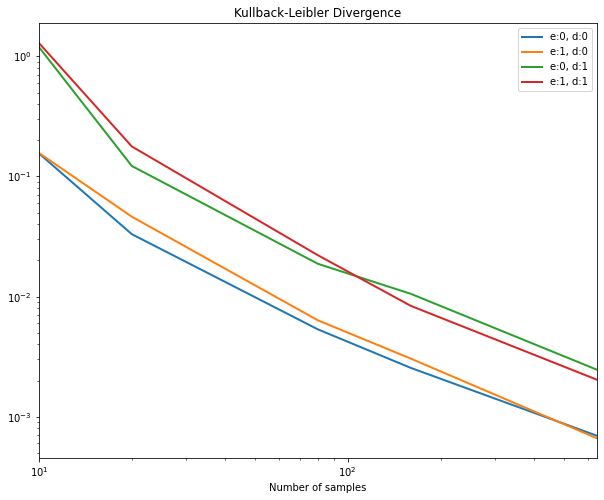

In [16]:
from utils import approx_error

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 80, 160, 640])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        likelihood_weighting,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leibler Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()